In [1]:
import os
import cv2
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from datetime import date,datetime

## 加载数据

In [7]:
train_images = np.load('./data/npy_data/784_session_all/train-pcap.npy')
train_labels = np.load('./data/npy_data/784_session_all/train-labels.npy')
test_images = np.load('./data/npy_data/784_session_all/test-pcap.npy')
test_labels = np.load('./data/npy_data/784_session_all/test-labels.npy')

In [8]:
print(train_images.shape, train_labels.shape, test_images.shape, test_labels.shape)

(49986, 784) (49986,) (5618, 784) (5618,)


## 训练网络

- 创建dataloader
- 定义模型
- 开始训练

In [9]:
import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.utils.checkpoint import checkpoint, checkpoint_sequential

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [12]:
train_images.reshape(-1, 1, 784).shape

(49986, 1, 784)

### 定义dataloader

In [13]:
# ---------
# 转换为tensor
# ---------
X_train = torch.from_numpy(train_images.reshape(-1, 1, 784)).float() # 输入 x 张量
X_test = torch.from_numpy(test_images.reshape(-1, 1, 784)).float()
Y_train = torch.from_numpy(train_labels).long() # 输入 y 张量
Y_test = torch.from_numpy(test_labels).long()
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

# ---------------
# 创建dataloader
# ---------------
MINIBATCH_SIZE = 200

trainDataset = torch.utils.data.TensorDataset(X_train, Y_train) # 合并训练数据和目标数据
trainDataloader = torch.utils.data.DataLoader(
    dataset=trainDataset,
    batch_size=MINIBATCH_SIZE,
    shuffle=True,
    num_workers=1           # set multi-work num read data
)

testDataset = torch.utils.data.TensorDataset(X_test, Y_test) # 数据路径
testDataloader = torch.utils.data.DataLoader(
    dataset=testDataset,
    batch_size=MINIBATCH_SIZE, # 批量大小
    shuffle=True, # 乱序
    num_workers=1 # 多进程
)

torch.Size([49986, 1, 784]) torch.Size([49986])
torch.Size([5618, 1, 784]) torch.Size([5618])


### 模型的定义

In [14]:
class cnn1d(nn.Module):
    def __init__(self):
        super(cnn1d, self).__init__()
        # 卷积层+池化层
        self.conv = nn.Sequential(
            # 第一层
            nn.Conv1d(kernel_size=25, in_channels=1, out_channels=32, stride=1, padding=12), # (1,784)->(32,784)
            nn.BatchNorm1d(32), # 加上BN的结果
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=3, stride=3, padding=1), # (32,784)->(32,262)
            # # 第二层
            nn.Conv1d(kernel_size=25, in_channels=32, out_channels=64, stride=1, padding=12), # (32,262)->(64,262)
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=3, stride=3, padding=1), # (64,262)->(64*88)
        )
        # 全连接层
        self.line = nn.Sequential(
            nn.Linear(in_features=88*64, out_features=1024),
            nn.Dropout(0.7),
            nn.Linear(in_features=1024, out_features=12)
        )
    def forward(self, x):
        x = self.conv(x) # 卷积层
        x = x.view(x.size(0), -1) # 展开
        x = self.line(x) # 全连接层
        return x

### 开始训练

In [15]:
# 模型初始化
Cnn = cnn1d().to(device) # 定义分类器

# 定义损失函数和优化器
loss_fn = nn.CrossEntropyLoss() # 定义损失函数
optimiser = optim.Adam(params=Cnn.parameters(), lr=0.001) # 定义优化器

print('开始训练.')
num_epochs = 100
total_step = len(trainDataloader) # 每一个epoch中的步骤
lossList = [] # 每一个epoch的loss
AccuryList = [] # 每一个epoch的accury
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size=20*300, gamma=0.9) # 学习率每20轮变为原来的90%
for epoch in range(num_epochs):
    Cnn.train() # 训练模式
    totalLoss = 0 # 计算训练集的平均loss(每一个epoch计算一次loss)
    for i, (images, labels) in enumerate(trainDataloader):
        images = images.to(device)
        labels = labels.to(device)
        pre = Cnn(images) # 模型的预测结果
        loss = loss_fn(pre, labels) # 计算误差
        # 反向传播
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        lr_scheduler.step() # lr的递减
        # 计算平均loss
        totalLoss = totalLoss + loss.item()
        # ---------
        # 打印结果
        # ---------
        if (i+2) % 100 == 0:
            t = datetime.now() #获取现在的时间
            print('Time {}, Epoch [{}/{}], Step [{}/{}], loss:{:.4f}'.format(t, epoch, num_epochs, i+1, total_step, totalLoss/(i+1)))
            # 看一下训练集准确率
            _, predicted = torch.max(pre.data, 1)
            total = labels.size(0)
            correct = (predicted == labels).sum().item()
            print('Training Accuracy: {}, Training Rate: {}'.format(100 * correct / total, optimiser.param_groups[0]['lr']))

    lossList.append(totalLoss/(i+1))
    # --------------------------
    # 每一个epoch对测试集进行测试
    # --------------------------
    Cnn.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in testDataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = Cnn(images) # 模型的预测结果(概率)
            _, predicted = torch.max(outputs.data, 1) # 模型的预测结果(对应到是哪一个label)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Test Accuracy of the model on the test images: {} %'.format(100 * correct / total))
    AccuryList.append(correct / total)
    print('-'*10)

 90.0498398006408 %
----------
Time 2021-01-07 11:25:59.614933, Epoch [42/100], Step [99/250], loss:0.1144
Training Accuracy: 93.5, Training Rate: 0.0009000000000000001
Time 2021-01-07 11:26:01.744863, Epoch [42/100], Step [199/250], loss:0.1177
Training Accuracy: 98.0, Training Rate: 0.0009000000000000001
Test Accuracy of the model on the test images: 90.38803844784621 %
----------
Time 2021-01-07 11:26:06.422034, Epoch [43/100], Step [99/250], loss:0.1168
Training Accuracy: 97.0, Training Rate: 0.0009000000000000001
Time 2021-01-07 11:26:08.480901, Epoch [43/100], Step [199/250], loss:0.1185
Training Accuracy: 95.5, Training Rate: 0.0009000000000000001
Test Accuracy of the model on the test images: 89.58704165183339 %
----------
Time 2021-01-07 11:26:13.123639, Epoch [44/100], Step [99/250], loss:0.1021
Training Accuracy: 96.0, Training Rate: 0.0009000000000000001
Time 2021-01-07 11:26:15.133509, Epoch [44/100], Step [199/250], loss:0.1011
Training Accuracy: 95.0, Training Rate: 0.00

In [16]:
# 打印最好的准确率
print(max(AccuryList))

0.9576361694553222


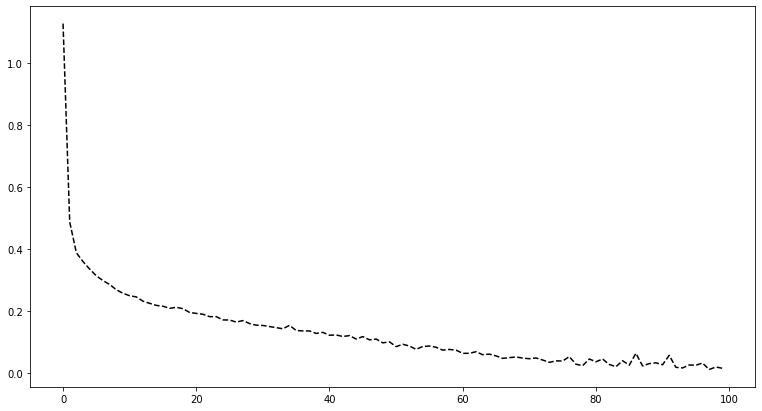

In [17]:
# 绘制loss的变化
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(13,7))
axes.plot(lossList, 'k--')

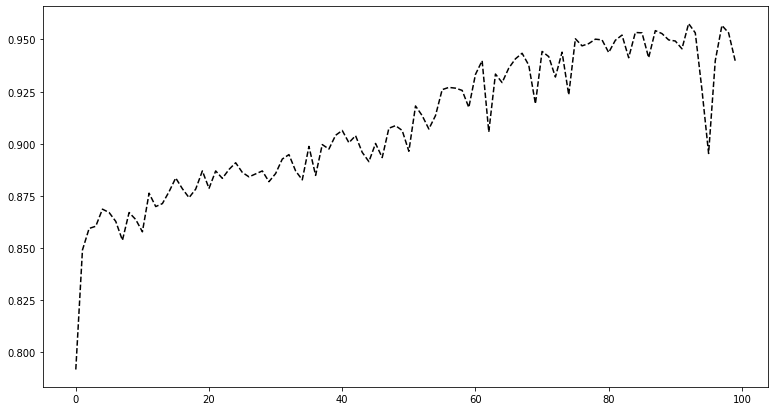

In [18]:
# 绘制准确率的变化
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(13,7))
axes.plot(AccuryList, 'k--')